# RNN WORKFLOW (UCI DATASET)
Status: **ON GOING**

In [1]:
# IMPORT ALL LIBRARIES
import sys
import os
import re
import string
import importlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../..")))


from sklearn.metrics import  ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from shared.metrics import compute_classic_metrics, save_evaluation_report

importlib.reload(sys.modules['shared.metrics'])



<module 'shared.metrics' from 'c:\\Users\\mosqu\\personal-projects\\dss_pit\\src\\shared\\metrics.py'>

In [3]:
df = pd.read_csv("../../../data/uci/cleaned_covid_lies.csv")

df.columns = ["text", "label"]

print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nLabel distribution:")
print(df['label'].value_counts())

print("\nData types and non-null values:")
df.info()

print("\nDescriptive statistics:")
print(df.describe())

Dataset shape: (6591, 2)

First 5 rows:
                                                text label
0                 coronavirus genetically engineered    na
1   blowing conch shell destroys coronavirus potency    na
2  swan dolphin swimming venice canal following c...    na
3                           cocaine cure coronavirus    na
4  observing janata curfew result reduction covid...    na

Label distribution:
label
na     6149
pos     288
neg     154
Name: count, dtype: int64

Data types and non-null values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6591 entries, 0 to 6590
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6591 non-null   object
 1   label   6591 non-null   object
dtypes: object(2)
memory usage: 103.1+ KB

Descriptive statistics:
                                      text label
count                                 6591  6591
unique                                  62     3
top     coronavirus 

In [4]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["label"])

print("Encoded labels (first 5):")
print(y[:5])
print("Original classes:")
print(label_encoder.classes_)

Encoded labels (first 5):
[0 0 0 0 0]
Original classes:
['na' 'neg' 'pos']


In [5]:
# Initialize Tokenizer
# Using num_words=None to keep all words, or specify a number if desired
tokenizer = Tokenizer(num_words=None, oov_token="<unk>")

# Fit tokenizer on the 'combined_text' column
tokenizer.fit_on_texts(df["text"])

# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(df["text"])

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print("First 5 text sequences (partial view):")
for i in range(5):
    print(sequences[i][:10])  # Print first 10 tokens of first 5 sequences

Vocabulary size: 234
First 5 text sequences (partial view):
[2, 20, 21]
[42, 43, 44, 45, 2, 46]
[47, 48, 49, 32, 33, 6, 3, 7]
[50, 4, 2]
[194, 195, 196, 197, 198, 3, 199]


In [6]:
# Determine an appropriate maximum sequence length
sequence_lengths = [len(seq) for seq in sequences]
max_sequence_length = int(np.percentile(sequence_lengths, 90))

# Pad the sequences
X = pad_sequences(
    sequences, maxlen=max_sequence_length, padding="post", truncating="post"
)

print(f"Original max sequence length: {max(sequence_lengths)}")
print(f"Selected max sequence length for padding: {max_sequence_length}")
print(f"Shape of padded sequences (X): {X.shape}")
print("First padded sequence (partial view):\n", X[0][: max_sequence_length // 10])

Original max sequence length: 14
Selected max sequence length for padding: 9
Shape of padded sequences (X): (6591, 9)
First padded sequence (partial view):
 []


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (5272, 9)
Shape of X_test: (1319, 9)
Shape of y_train: (5272,)
Shape of y_test: (1319,)


In [8]:
vocabulary_size = len(tokenizer.word_index) + 1

# Get number of classes
num_classes = len(label_encoder.classes_)

# Define the model
model = Sequential(
    [
        Embedding(input_dim=vocabulary_size, output_dim=128),
        LSTM(units=128),
        Dense(units=num_classes, activation="softmax"),
    ]
)

# Explicitly build the model before compiling or summarizing
# input_shape should be (batch_size, sequence_length)
model.build(input_shape=(None, max_sequence_length))

# Compile the model
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Print model summary
print("RNN Model Summary:")
model.summary()

RNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 9, 128)         │        30,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,051 (633.01 KB)

 Trainable params: 162,051 (633.01 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
print("Model training complete. Training history stored in 'history' variable.")

Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9292 - loss: 0.2895 - val_accuracy: 0.9303 - val_loss: 0.2206
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9323 - loss: 0.2187 - val_accuracy: 0.9249 - val_loss: 0.2134
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9334 - loss: 0.2108 - val_accuracy: 0.9340 - val_loss: 0.2196
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9366 - loss: 0.2054 - val_accuracy: 0.9340 - val_loss: 0.2077
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9357 - loss: 0.2039 - val_accuracy: 0.9303 - val_loss: 0.2104
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9359 - loss: 0.1997 - val_accuracy: 0.9348 - val_loss: 0.2062
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9380 - loss: 0.2005 - val_accuracy: 0.9348 - val_loss: 0.2107
Epoch 8/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9346 - loss: 0.1972 - val_accu

In [11]:
# Make predictions on the test set
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Generate and print the classification report
print("Classification Report:")
# Provide all possible labels to classification_report to match target_names
print(
    classification_report(
        y_test,
        y_pred,
        labels=np.arange(num_classes),
        target_names=label_encoder.classes_,
        zero_division=0,
    )
)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Classification Report:
              precision    recall  f1-score   support

          na       0.95      0.99      0.97      1226
         neg       0.58      0.40      0.47        35
         pos       0.50      0.19      0.28        58

    accuracy                           0.93      1319
   macro avg       0.68      0.52      0.57      1319
weighted avg       0.92      0.93      0.92      1319



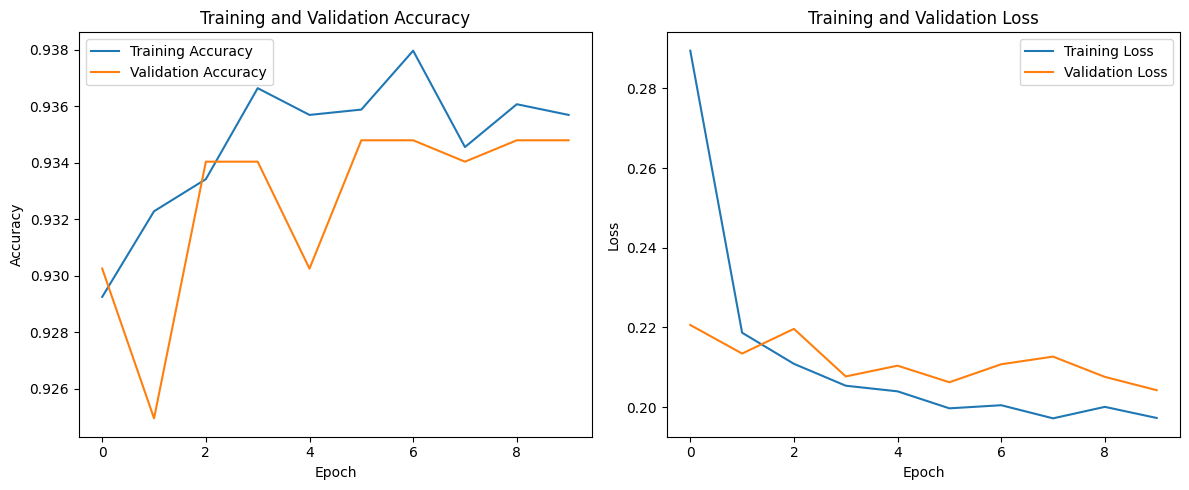

In [12]:
# Get training history
hist = history.history

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist['accuracy'], label='Training Accuracy')
plt.plot(hist['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(hist['loss'], label='Training Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# COMPUTE CLASS METRICS
metrics = compute_classic_metrics(y_test, y_pred)

print("Accuracy:", metrics["accuracy"])
print("F1 Score:", metrics["f1_score"])
print(metrics["report"])

Accuracy: 0.9347990902198635
F1 Score: 0.9233060513240389
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1226
           1       0.58      0.40      0.47        35
           2       0.50      0.19      0.28        58

    accuracy                           0.93      1319
   macro avg       0.68      0.52      0.57      1319
weighted avg       0.92      0.93      0.92      1319



In [15]:
class_names = label_encoder.classes_

cm = confusion_matrix(y_test, y_pred)
print("Raw confusion matrix:")
print(cm)

Raw confusion matrix:
[[1208    8   10]
 [  20   14    1]
 [  45    2   11]]


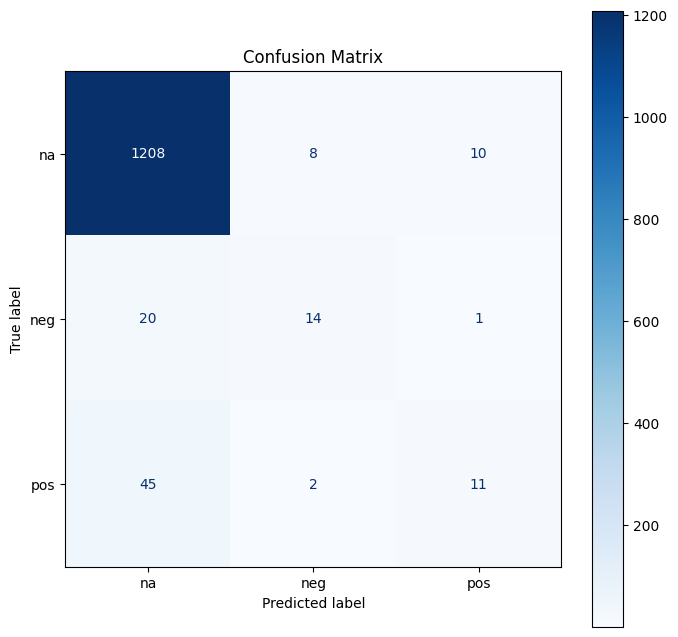

In [16]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Adjust the plot size and color map
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d') # 'd' formats as integer
plt.title("Confusion Matrix")
plt.show()

In [18]:
save_evaluation_report(metrics, "../../../deep_models/uci_results/rnn_evaluation_report.json")

Evaluation report saved to ../../../deep_models/uci_results/rnn_evaluation_report.json
